# MODEL 1: DISASTER RELEVANCE VERIFICATION

### DATA WRANGLING
Using a dataset of tweets provided by [Kaggle](https://www.kaggle.com/jannesklaas/disasters-on-social-media) sourced originally from Figure-Eight (acquired by [Appen](www.appen.com)), a blackbox model based on neural networks was developed.

The purpose of the model is to be able to accept any tweet as an input and return a classification of whether the tweet is related to a distaster or not.

The data originally had a 3rd classification "Can't Decide" along with "Relevant" & "Not Relevant", therefore all rows with the 3rd classification were removed. The sample size was barely affected as it only dropped from 10876 to 10860.

Additionally, the text contents of each tweet underwent extensive cleaning as provided by Kaggle user [georgesaavedra](https://www.kaggle.com/georgesaavedra/best-nlp-disaster-tweets-classifier):
- URL & HTML removal
- emoji removal
- line breaks to spaces
- common abbreviations/slang/typos converted to real words
- punctuation & number removal (retaining only letters)
- lower-cased

As neural networks require array inputs, all tweets were tokenized and converted to sequences of max length 60 with padding, if required. Max length 60 was selected as the max length of a tweet is 280 characters which is 55 words on average. 

To further improve the impact of each word, a pretrained Google News corpus was utilized to create a word embedding matrix where recognized words from all tweets were assigned a weight predetermined by Google. This weight matrix was used for the weight parameter in the embedding input layer of the neural network.

### MODELING
Through trial and error of numerous neural network implementations, a low-loss, low-variance model was developed with an accuracy of **83%**:
- RESULTS: loss: 0.3918 - acc: 0.8354 - val_loss: 0.4055 - val_acc: 0.8310

Model composition:
- Stochastic Gradient Descent (SGD) optimizer
    - Adam resulted in very overfit models with high variance
- Embedding input layer
- 2 Conv1D layers (32 & 64 filters respectively)
- 1 Dense layer (32 filters)
- Dense sigmoid output layer 
    - Batchnomalization + Dropout applied to all layers except output
    - AveragePooling1D and GlobalAveragePooling1D (similar to AveragePooling+Flatten) applied to all Conv1D layers
    
Based the best results from epoch 129/200 were re-loaded and the model was saved to 'pretrained_models/relevance_model.hdf5' for re-use in the web-app.

### CONCLUSION
Through numerous modifications to the model, including uses of LSTM layers, 83% would be the best performance. Despite this fact, we've concluded that it's okay to have the remaining 17% unaccounted for as tweets that are considered false positive (predicted as relevant, but is not) would end up being classified as misinformation in the 2nd model - the disaster credibility model.

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import re
import string
import gensim

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Embedding, BatchNormalization, Dropout, AveragePooling1D, GlobalAveragePooling1D, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Random seed set for reproduced results
np.random.seed(42)
tf.random.set_seed(42)

# 1. DATA WRANGLING

In [4]:
# Training dataset
# from https://www.kaggle.com/jannesklaas/disasters-on-social-media
    # sourced from figure-eight, formally Crowdflower, acquired by Appen
    
train = pd.read_csv('../datasets/disaster_relevance.csv')
train.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN


In [5]:
# Retaining only 2 columns
train = train[['choose_one', 'text']]

In [6]:
train.head(1)

,choose_one,text
0,Relevant,Just happened a terrible car crash


In [7]:
# No missing values
train.isnull().sum()

choose_one    0
text          0
dtype: int64

In [8]:
# Shape & unique targets
print(train.shape)
train['choose_one'].unique()

(10876, 2)


array(['Relevant', 'Not Relevant', "Can't Decide"], dtype=object)

In [9]:
# Omit 'can't decide'
train = train[train['choose_one'] != "Can't Decide"]
print(train.shape)
train['choose_one'].unique()

(10860, 2)


array(['Relevant', 'Not Relevant'], dtype=object)

In [10]:
# Feature & target defined
X = train['text']
y = train['choose_one'].map({'Relevant':1, 'Not Relevant':0})

X[0], y[0]

('Just happened a terrible car crash', 1)

In [11]:
# Distribution near balanced
y.value_counts(normalize=True)

0    0.569705
1    0.430295
Name: choose_one, dtype: float64

### 1.1 INITIAL CLEANING

In [12]:
# Pre-cleaning
X

0                       Just happened a terrible car crash
1        Our Deeds are the Reason of this #earthquake M...
2        Heard about #earthquake is different cities, s...
3        there is a forest fire at spot pond, geese are...
4                   Forest fire near La Ronge Sask. Canada
                               ...                        
10871    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
10872    Police investigating after an e-bike collided ...
10873    The Latest: More Homes Razed by Northern Calif...
10874    MEG issues Hazardous Weather Outlook (HWO) htt...
10875    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 10860, dtype: object

In [13]:
# Initial cleaning

def clean(text):
    
    #URLs
    text = re.sub(r'https?://\S+|www\.\S+','', text)
    
    #HTMLs
    text = re.sub(r'<.*?>', '', text)
    
    #Emojis
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    text = emojis.sub(r'', text)
    
    #Line breaks
    text = re.sub(r'\n', '', text)
    
    # Alphabets only
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    return text
    
X = X.apply(clean)

In [14]:
# post-cleaning round 1
X

0                       Just happened a terrible car crash
1        Our Deeds are the Reason of this earthquake Ma...
2        Heard about earthquake is different cities sta...
3        there is a forest fire at spot pond geese are ...
4                    Forest fire near La Ronge Sask Canada
                               ...                        
10871                        M  UTCkm S of Volcano Hawaii 
10872    Police investigating after an ebike collided w...
10873    The Latest More Homes Razed by Northern Califo...
10874            MEG issues Hazardous Weather Outlook HWO 
10875    CityofCalgary has activated its Municipal Emer...
Name: text, Length: 10860, dtype: object

In [15]:
# Secondary cleaner
# Twitter cleaner supplied by
# https://www.kaggle.com/georgesaavedra/best-nlp-disaster-tweets-classifier

def clean2(tweet):
  # Acronyms and miswritten words
  tweet = re.sub(r"Typhoon-Devastated", "typhoon devastated", tweet)
  tweet = re.sub(r"TyphoonDevastated", "typhoon devastated", tweet)
  tweet = re.sub(r"typhoondevastated", "typhoon devastated", tweet)
  tweet = re.sub(r"MH370", "Malaysia Airlines Flight", tweet)
  tweet = re.sub(r"MH", "Malaysia Airlines Flight", tweet)
  tweet = re.sub(r"mh370", "Malaysia Airlines Flight", tweet)
  tweet = re.sub(r"year-old", "years old", tweet)
  tweet = re.sub(r"yearold", "years old", tweet)
  tweet = re.sub(r"yr old", "years old", tweet)
  tweet = re.sub(r"PKK", "Kurdistan Workers Party", tweet)
  tweet = re.sub(r"MP", "madhya pradesh", tweet)
  tweet = re.sub(r"rly", "railway", tweet)
  tweet = re.sub(r"CDT", "Central Daylight Time", tweet)
  tweet = re.sub(r"sensorsenso", "sensor senso", tweet)
  tweet = re.sub(r"pm", "", tweet)
  tweet = re.sub(r"PM", "", tweet)
  tweet = re.sub(r"nan", '', tweet)
  tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
  tweet = re.sub(r"epicente", "epicenter", tweet)
  tweet = re.sub(r"epicenterr", "epicenter", tweet)
  tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
  tweet = re.sub(r"prebreak", "pre break", tweet)
  tweet = re.sub(r"nowplaying", "now playing", tweet)
  tweet = re.sub(r"RT", "retweet", tweet)
  tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
  tweet = re.sub(r"LondonFire", "London Fire", tweet)
  tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
  tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
  tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
  tweet = re.sub(r"withweapons", "with weapons", tweet)
  tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
  tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
  tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
  tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)

  # Special characters
  tweet = re.sub(r"%20", "", tweet)
  tweet = re.sub(r"%", "", tweet)
  tweet = re.sub(r"@", "", tweet)
  tweet = re.sub(r"#", '', tweet)
  tweet = re.sub(r"'", '', tweet)
  tweet = re.sub(r"\x89û_", '', tweet)
  tweet = re.sub(r"\x89ûò", '', tweet)
  tweet = re.sub(r"16yr", "16 year", tweet)
  tweet = re.sub(r"re\x89û_", '', tweet)
  tweet = re.sub(r"\x89û", '', tweet)
  tweet = re.sub(r"\x89Û", '', tweet)
  tweet = re.sub(r"re\x89Û", "re ", tweet)
  tweet = re.sub(r"re\x89û", "re ", tweet)
  tweet = re.sub(r"\x89ûª", "'", tweet)
  tweet = re.sub(r"\x89û", '', tweet)
  tweet = re.sub(r"\x89ûò", '', tweet)
  tweet = re.sub(r"\x89Û_", "", tweet)
  tweet = re.sub(r"\x89ÛÒ", "", tweet)
  tweet = re.sub(r"\x89ÛÓ", "", tweet)
  tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
  tweet = re.sub(r"\x89ÛÏ", "", tweet)
  tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
  tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
  tweet = re.sub(r"\x89Û÷", "", tweet)
  tweet = re.sub(r"\x89Ûª", "", tweet)
  tweet = re.sub(r"\x89Û\x9d", "", tweet)
  tweet = re.sub(r"å_", "", tweet)
  tweet = re.sub(r"\x89Û¢", "", tweet)
  tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
  tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
  tweet = re.sub(r"åÊ", "", tweet)
  tweet = re.sub(r"åÈ", "", tweet)
  tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
  tweet = re.sub(r"Ì©", "e", tweet)
  tweet = re.sub(r"å¨", "", tweet)
  tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
  tweet = re.sub(r"åÇ", "", tweet)
  tweet = re.sub(r"å£3million", f"3 million", tweet)
  tweet = re.sub(r"åÀ", "", tweet)

  # Contractions
  tweet = re.sub(r"he's", "he is", tweet)
  tweet = re.sub(r"there's", "there is", tweet)
  tweet = re.sub(r"We're", "We are", tweet)
  tweet = re.sub(r"That's", "That is", tweet)
  tweet = re.sub(r"won't", "will not", tweet)
  tweet = re.sub(r"they're", "they are", tweet)
  tweet = re.sub(r"Can't", "Cannot", tweet)
  tweet = re.sub(r"wasn't", "was not", tweet)
  tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
  tweet = re.sub(r"aren't", "are not", tweet)
  tweet = re.sub(r"isn't", "is not", tweet)
  tweet = re.sub(r"What's", "What is", tweet)
  tweet = re.sub(r"haven't", "have not", tweet)
  tweet = re.sub(r"hasn't", "has not", tweet)
  tweet = re.sub(r"There's", "There is", tweet)
  tweet = re.sub(r"He's", "He is", tweet)
  tweet = re.sub(r"It's", "It is", tweet)
  tweet = re.sub(r"You're", "You are", tweet)
  tweet = re.sub(r"I'M", "I am", tweet)
  tweet = re.sub(r"Im", "I am", tweet)
  tweet = re.sub(r"shouldn't", "should not", tweet)
  tweet = re.sub(r"wouldn't", "would not", tweet)
  tweet = re.sub(r"i'm", "I am", tweet)
  tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
  tweet = re.sub(r"I'm", "I am", tweet)
  tweet = re.sub(r"Isn't", "is not", tweet)
  tweet = re.sub(r"Here's", "Here is", tweet)
  tweet = re.sub(r"you've", "you have", tweet)
  tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
  tweet = re.sub(r"we're", "we are", tweet)
  tweet = re.sub(r"what's", "what is", tweet)
  tweet = re.sub(r"couldn't", "could not", tweet)
  tweet = re.sub(r"we've", "we have", tweet)
  tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
  tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
  tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
  tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
  tweet = re.sub(r"who's", "who is", tweet)
  tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
  tweet = re.sub(r"y'all", "you all", tweet)
  tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
  tweet = re.sub(r"would've", "would have", tweet)
  tweet = re.sub(r"it'll", "it will", tweet)
  tweet = re.sub(r"we'll", "we will", tweet)
  tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
  tweet = re.sub(r"We've", "We have", tweet)
  tweet = re.sub(r"he'll", "he will", tweet)
  tweet = re.sub(r"Y'all", "You all", tweet)
  tweet = re.sub(r"Weren't", "Were not", tweet)
  tweet = re.sub(r"Didn't", "Did not", tweet)
  tweet = re.sub(r"they'll", "they will", tweet)
  tweet = re.sub(r"they'd", "they would", tweet)
  tweet = re.sub(r"DON'T", "DO NOT", tweet)
  tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
  tweet = re.sub(r"they've", "they have", tweet)
  tweet = re.sub(r"i'd", "I would", tweet)
  tweet = re.sub(r"should've", "should have", tweet)
  tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
  tweet = re.sub(r"where's", "where is", tweet)
  tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
  tweet = re.sub(r"we'd", "we would", tweet)
  tweet = re.sub(r"i'll", "I will", tweet)
  tweet = re.sub(r"weren't", "were not", tweet)
  tweet = re.sub(r"They're", "They are", tweet)
  tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
  tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
  tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
  tweet = re.sub(r"let's", "let us", tweet)
  tweet = re.sub(r"it's", "it is", tweet)
  tweet = re.sub(r"can't", "can not", tweet)
  tweet = re.sub(r"cant", "can not", tweet)
  tweet = re.sub(r"don't", "do not", tweet)
  tweet = re.sub(r"dont", "do not", tweet)
  tweet = re.sub(r"you're", "you are", tweet)
  tweet = re.sub(r"i've", "I have", tweet)
  tweet = re.sub(r"that's", "that is", tweet)
  tweet = re.sub(r"i'll", "I will", tweet)
  tweet = re.sub(r"doesn't", "does not", tweet)
  tweet = re.sub(r"i'd", "I would", tweet)
  tweet = re.sub(r"didn't", "did not", tweet)
  tweet = re.sub(r"ain't", "am not", tweet)
  tweet = re.sub(r"you'll", "you will", tweet)
  tweet = re.sub(r"I've", "I have", tweet)
  tweet = re.sub(r"Don't", "do not", tweet)
  tweet = re.sub(r"I'll", "I will", tweet)
  tweet = re.sub(r"I'd", "I would", tweet)
  tweet = re.sub(r"Let's", "Let us", tweet)
  tweet = re.sub(r"you'd", "You would", tweet)
  tweet = re.sub(r"It's", "It is", tweet)
  tweet = re.sub(r"Ain't", "am not", tweet)
  tweet = re.sub(r"Haven't", "Have not", tweet)
  tweet = re.sub(r"Could've", "Could have", tweet)
  tweet = re.sub(r"youve", "you have", tweet)  
  tweet = re.sub(r"donå«t", "do not", tweet)

  return tweet

X = X.apply(clean2)

In [16]:
# Post-cleaning round 2
X

0                       Just happened a terrible car crash
1        Our Deeds are the Reason of this earthquake Ma...
2        Heard about earthquake is different cities sta...
3        there is a forest fire at spot pond geese are ...
4                    Forest fire near La Ronge Sask Canada
                               ...                        
10871                        M  UTCkm S of Volcano Hawaii 
10872    Police investigating after an ebike collided w...
10873    The Latest More Homes Razed by Northern Califo...
10874            MEG issues Hazardous Weather Outlook HWO 
10875    CityofCalgary has activated its Municipal Emer...
Name: text, Length: 10860, dtype: object

In [17]:
# Final cleaning
def clean3(text):
    
    #Punctuations
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    
    #Extra white-space
    text = re.sub(r' +', ' ', text)
    
    return text.lower()

X = X.apply(clean3)

In [18]:
# Final cleaned text
X

0                       just happened a terrible car crash
1        our deeds are the reason of this earthquake ma...
2        heard about earthquake is different cities sta...
3        there is a forest fire at spot pond geese are ...
4                    forest fire near la ronge sask canada
                               ...                        
10871                         m utckm s of volcano hawaii 
10872    police investigating after an ebike collided w...
10873    the latest more homes razed by northern califo...
10874            meg issues hazardous weather outlook hwo 
10875    cityofcalgary has activated its municipal emer...
Name: text, Length: 10860, dtype: object

In [19]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42, 
                                                    stratify=y,
                                                    test_size=0.2)

In [20]:
X_train.shape

(8688,)

### 1.2 TOKENIZATION & SEQUENCING

In [21]:
# Max words in tokenizer index
max_words = 100000

# Tokenizer fit, sequenced, padded
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(train_seq, maxlen=60)
X_test = pad_sequences(test_seq, maxlen=X_train.shape[1])

# Word index stored for embedding matrix
word_index = tokenizer.word_index

# Dimensions for embedding matrix
embedding_dim = 300
vocab_size = min(len(word_index)+1, max_words)

In [22]:
X_train.shape

(8688, 60)

In [23]:
# Solution by:
    # https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring

#Store tokenizer fit for future preprocessing
import pickle

# Saved
with open('relevance_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
## Can be loaded for future use:
    ## from tensorflow.keras.preprocessing.text import Tokenizer 
    ## import pickle
    ##
    ## with open('relevance_tokenizer.pickle', 'rb') as handle:
    ##     tokenizer = pickle.load(handle)

In [24]:
# GENSIM IMPORT ON GOOGLE PRETRAINED WORD2VEC
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')
    # If you have the physical .bin file downloaded:
        # wv = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

    # Empty matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Tracking unrecognized words
unknown = []

# Iterate through fitted word index and
# extract weighted vectors from pretrained Google word vector
for word, index in word_index.items():
    if index >= max_words:
        continue
    try:
        embedding_vector = wv[word] # extract word vector
        embedding_matrix[index] = embedding_vector # store word vector
    except:
        unknown.append(word)

In [25]:
# 7059 unrecognized words
print(len(unknown))

# 20 random unrecognized words
np.random.choice(unknown, 20)

7059


array(['nickcocofree', 'kwxggt', 'nickwilson', 'syvret',
       'theresmorewherethatcamefrom', 'nxwestmidlands', 'nurgle',
       'dratomic', 'spokane', 'casewrites', 'arobotlegion',
       'worldrunners', 'seattletimes', 'sanonofre', 'grumpout',
       'originalfunko', 'farrakhan', 'cossackshussars', 'policerun',
       'fighterbut'], dtype='<U51')

In [26]:
# Targets converted to arrays
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Shapes
print('X_train/test: ', X_train.shape,X_test.shape)
print('y_train/test: ', y_train.shape,y_test.shape)

X_train/test:  (8688, 60) (2172, 60)
y_train/test:  (8688,) (2172,)


# 2. MODELING
- Deep Neural Network:
    - Embedding input layer
    - 2 Conv1D layers + 1 Dense layer
    - Dense output layer
- Previously utilized Bidirectional LSTM instead of second CNN with similar results, but replaced due to ineffient use of memory & computational power

In [42]:
# Model
model = Sequential()

# Embedding input
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                   trainable=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# 1 CNN layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling1D())
model.add(Dropout(0.25))

# 1 CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.25))

# 1 Dense layer
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Sigmoid output
model.add(Dense(1, activation='sigmoid'))


# Model Compiled
model.compile(loss='binary_crossentropy',
             optimizer='SGD',
             metrics=['acc'])

# Summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 300)         5660100   
                                                                 
 batch_normalization_28 (Bat  (None, None, 300)        1200      
 chNormalization)                                                
                                                                 
 dropout_27 (Dropout)        (None, None, 300)         0         
                                                                 
 conv1d_15 (Conv1D)          (None, None, 32)          28832     
                                                                 
 batch_normalization_29 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 average_pooling1d_11 (Avera  (None, None, 32)       

In [43]:
# Early stop 25 epochs after lowest validation, best weights restored
early = EarlyStopping(monitor='val_loss', patience=25, min_delta = 0.0001, restore_best_weights=True)

# Store best weights for future use without re-training
filepath = "weights/weights-improvement-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, mode='min', save_weights_only=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=64,
                    epochs=200,
                    callbacks=[early, checkpoint],
                    verbose=1)

Epoch 1/200
136/136 [==============================] - 2s 11ms/step - loss: 0.7890 - acc: 0.5992 - val_loss: 0.6726 - val_acc: 0.5695
Epoch 2/200
136/136 [==============================] - 1s 6ms/step - loss: 0.6522 - acc: 0.6702 - val_loss: 0.7111 - val_acc: 0.5700
Epoch 3/200
136/136 [==============================] - 1s 5ms/step - loss: 0.6005 - acc: 0.7032 - val_loss: 0.6237 - val_acc: 0.6381
Epoch 4/200
136/136 [==============================] - 1s 6ms/step - loss: 0.5645 - acc: 0.7218 - val_loss: 0.5640 - val_acc: 0.7122
Epoch 5/200
136/136 [==============================] - 1s 5ms/step - loss: 0.5431 - acc: 0.7311 - val_loss: 0.5653 - val_acc: 0.7274
Epoch 6/200
136/136 [==============================] - 1s 10ms/step - loss: 0.5410 - acc: 0.7379 - val_loss: 0.4824 - val_acc: 0.7841
Epoch 7/200
136/136 [==============================] - 1s 6ms/step - loss: 0.5218 - acc: 0.7505 - val_loss: 0.5233 - val_acc: 0.7523
Epoch 8/200
136/136 [==============================] - 1s 6ms/step 

136/136 [==============================] - 1s 8ms/step - loss: 0.3926 - acc: 0.8321 - val_loss: 0.4229 - val_acc: 0.8200
Epoch 124/200
136/136 [==============================] - 1s 10ms/step - loss: 0.3941 - acc: 0.8323 - val_loss: 0.4415 - val_acc: 0.8172
Epoch 125/200
136/136 [==============================] - 1s 9ms/step - loss: 0.3936 - acc: 0.8313 - val_loss: 0.4078 - val_acc: 0.8306
Epoch 126/200
136/136 [==============================] - 1s 11ms/step - loss: 0.3911 - acc: 0.8337 - val_loss: 0.4065 - val_acc: 0.8315
Epoch 127/200
136/136 [==============================] - 1s 5ms/step - loss: 0.3900 - acc: 0.8300 - val_loss: 0.4106 - val_acc: 0.8278
Epoch 128/200
136/136 [==============================] - 1s 4ms/step - loss: 0.3927 - acc: 0.8330 - val_loss: 0.4084 - val_acc: 0.8310
Epoch 129/200
136/136 [==============================] - 1s 5ms/step - loss: 0.3918 - acc: 0.8354 - val_loss: 0.4055 - val_acc: 0.8310
Epoch 130/200
136/136 [==============================] - 1s 10ms/st

## 2.1 RESULTS
### || CNN || SGD || Google W2V weights || Dropout= 0.5embedding/0.25CNN/0.4Dense || Filters=32CNN/64CNN/32Dense ||
    
- **SDG**
    - loss: 0.3918 - acc: 0.8354 - val_loss: 0.4055 - val_acc: 0.8310

### 2.2 MODEL SAVING FOR RE-USE

In [48]:
# Reload best weight from epoch 129/200
model.load_weights('weights/weights-improvement-129-0.4055.hdf5')

# Save model
model.save('pretrained_models/relevance_model.hdf5')

### TESTING

In [29]:
test.head()

,id,keyword,location,text,target,predictions
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1


TEST RESULTS
ACCURACY: 0.7128712871287128
F1 SCORE: 0.6233766233766234
ROC AUC: 0.7105882352941176


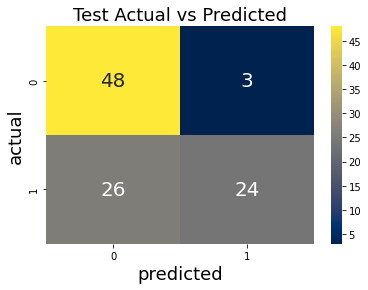

In [33]:
# Test on Kaggle competition dataset
    # A different kaggle dataset that also has disaster tweets
test = pd.read_csv('../datasets/validation_data.csv')

# Preprocessing
text_raw = test['text']
test_cleaned = text_raw.apply(clean).apply(clean2).apply(clean3)
test_seq = tokenizer.texts_to_sequences(test_cleaned)
test_padded = pad_sequences(test_seq, maxlen=60)

# Predictions
test['predictions'] = (model.predict(test_padded)>0.5).astype(int)

# Scores
acc = accuracy_score(test['disaster_related'], test['predictions'])
f1 = f1_score(test['disaster_related'], test['predictions'])
roc_auc = roc_auc_score(test['disaster_related'], test['predictions'])

print('TEST RESULTS')
print(f'ACCURACY: {acc}')
print(f'F1 SCORE: {f1}')
print(f'ROC AUC: {roc_auc}')

# Confusion matrix
cm = confusion_matrix(test['disaster_related'], test['predictions'])
sns.heatmap(cm, cmap= 'cividis', annot=True, fmt='g', annot_kws={'size':20})
plt.xlabel('predicted', fontsize=18)
plt.ylabel('actual', fontsize=18)
plt.title('Test Actual vs Predicted', fontsize=18)
plt.show()

2022-02-06 23:18:58.381975: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 22640400 exceeds 10% of free system memory.


TEST RESULTS
ACCURACY: 0.8645737554183633
F1 SCORE: 0.8284811179504241
ROC AUC: 0.8518289714576444


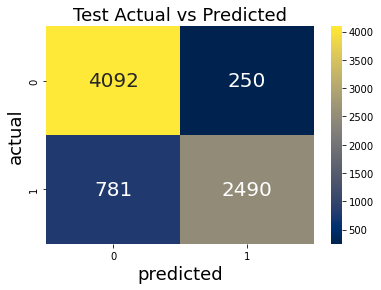

In [31]:
# Test on Kaggle competition dataset
    # A different kaggle dataset that also has disaster tweets
test = pd.read_csv('../datasets/disaster_competition.csv')

# Preprocessing
text_raw = test['text']
test_cleaned = text_raw.apply(clean).apply(clean2).apply(clean3)
test_seq = tokenizer.texts_to_sequences(test_cleaned)
test_padded = pad_sequences(test_seq, maxlen=60)

# Predictions
test['predictions'] = (model.predict(test_padded)>0.5).astype(int)

# Scores
acc = accuracy_score(test['target'], test['predictions'])
f1 = f1_score(test['target'], test['predictions'])
roc_auc = roc_auc_score(test['target'], test['predictions'])

print('TEST RESULTS')
print(f'ACCURACY: {acc}')
print(f'F1 SCORE: {f1}')
print(f'ROC AUC: {roc_auc}')

# Confusion matrix
cm = confusion_matrix(test['target'], test['predictions'])
sns.heatmap(cm, cmap= 'cividis', annot=True, fmt='g', annot_kws={'size':20})
plt.xlabel('predicted', fontsize=18)
plt.ylabel('actual', fontsize=18)
plt.title('Test Actual vs Predicted', fontsize=18)
plt.show()